In [53]:
#To read everything corrected so it can be read in Panda
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

observations_df = pd.read_csv(r'mushrom_observations.csv', delimiter = ';')
observations_df.head()
characteristics_df = pd.read_csv(r'mushroom_characteristics.csv', delimiter = ';')
characteristics_df.head()

,family,name,class,cap-diameter,cap-shape,Cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,Spore-print-color,habitat,season
0,Amanita Family,Fly Agaric,p,"[10, 20]","[x, f]","[g, h]","[e, o]",[f],[e],NaN,...,[s],[y],[w],[u],[w],[t],"[g, p]",NaN,[d],"[u, a, w]"
1,Amanita Family,Panther Cap,p,"[5, 10]","[p, x]",[g],[n],[f],[e],NaN,...,NaN,[y],[w],[u],[w],[t],[p],NaN,[d],"[u, a]"
2,Amanita Family,False Panther Cap,p,"[10, 15]","[x, f]",NaN,"[g, n]",[f],[e],NaN,...,NaN,NaN,[w],[u],[w],[t],"[e, g]",NaN,[d],"[u, a]"
3,Amanita Family,The Blusher,e,"[5, 15]","[x, f]",NaN,[n],[t],NaN,NaN,...,[b],NaN,[w],[u],[w],[t],[g],NaN,[d],"[u, a]"
4,Amanita Family,Death Cap,p,"[5, 12]","[x, f]",[h],[r],[f],NaN,[c],...,NaN,NaN,[w],[u],[w],[t],"[g, p]",NaN,[d],"[u, a]"


In [3]:
#Basic inspections
observations_df.info()
characteristics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [4]:
# Standardise column names (lowercase and replace hyphens with underscores)
observations_df.columns = [col.lower().replace('-', '_') for col in observations_df.columns]
characteristics_df.columns = [col.lower().replace('-', '_') for col in characteristics_df.columns]

In [5]:
# Separate columns by type, remove duplicates using set
categorical_cols = list(set(
    observations_df.select_dtypes(include='object').columns.tolist() +
    characteristics_df.select_dtypes(include='object').columns.tolist()
))

numerical_cols = list(set(
    observations_df.select_dtypes(include='float64').columns.tolist() +
    characteristics_df.select_dtypes(include='float64').columns.tolist()
))

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)

Categorical: ['has_ring', 'stem_width', 'spore_print_color', 'habitat', 'gill_color', 'stem_color', 'stem_surface', 'name', 'veil_type', 'does_bruise_or_bleed', 'cap_diameter', 'cap_color', 'cap_shape', 'gill_spacing', 'season', 'stem_height', 'gill_attachment', 'family', 'veil_color', 'stem_root', 'ring_type', 'class', 'cap_surface']
Numerical: ['cap_diameter', 'stem_height', 'stem_width']


In [18]:
# Combine datasets
# Add a column to track origin of my sample from the original dataset
observations_df['source'] = 'observations'
characteristics_df['source'] = 'characteristics'

# Standardise column orders and align schemas
common_cols = set(observations_df.columns).intersection(characteristics_df.columns)
common_cols = list(common_cols - {'source'})  # exclude 'source' if added above

# Add a column to track origin of sample
observations_df['source'] = 'observations'
characteristics_df['source'] = 'characteristics'

# Concatenate keeping all columns (union), missing columns filled with NaN
combined_df = pd.concat([observations_df, characteristics_df], ignore_index=True, sort=False)

print("Common columns:", common_cols)

# 1. Check the shape before and after
print("Observations shape:", observations_df.shape)
print("Characteristics shape:", characteristics_df.shape)
print("Combined shape:", combined_df.shape)

# 2. Check if columns from both dataframes are present
print("\nCombined DataFrame columns:")
print(combined_df.columns.tolist())

# 3. Check a random row to confirm columns from both sides are merged
print("\nSample merged row:")
print(combined_df.sample(3).T)

# 4. Check one for each source
# Select one sample row from observations in combined_df
obs_sample = combined_df[combined_df['source'] == 'observations'].sample(1).T

# Select one sample row from characteristics in combined_df
char_sample = combined_df[combined_df['source'] == 'characteristics'].sample(1).T

print("Sample from observations and characteristics (combined dataset):")
print(obs_sample, "\n", char_sample)

Common columns: ['has_ring', 'stem_width', 'spore_print_color', 'habitat', 'gill_color', 'stem_color', 'stem_surface', 'veil_color', 'veil_type', 'does_bruise_or_bleed', 'cap_diameter', 'stem_root', 'ring_type', 'cap_color', 'cap_shape', 'class', 'gill_spacing', 'season', 'stem_height', 'gill_attachment', 'cap_surface']
Observations shape: (61069, 22)
Characteristics shape: (173, 24)
Combined shape: (61242, 24)

Combined DataFrame columns:
['class', 'cap_diameter', 'cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color', 'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color', 'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color', 'habitat', 'season', 'source', 'family', 'name']

Sample merged row:
                             53148         4152          2220 
class                            e             p             p
cap_diameter                  7.75          2.57          7.24
cap_shape    

In [20]:
# 1. Define categorical columns from combined_df (excluding 'class' and 'source')
categorical_cols = combined_df.select_dtypes(include='object').columns.tolist()
target = 'class'

# Make sure 'class' and 'source' are excluded from categorical features
categorical_cols = [col for col in categorical_cols if col not in [target, 'source']]

# Optional: check if target exists and has no missing values
print(f"Number of missing values in '{target}':", combined_df[target].isna().sum())
'''

Number of missing values in 'class': 0


'\n# Store top values associated with poisonous\npoisonous_matrix = {}\n\nfor col in categorical_cols:\n    # Crosstab with row-wise normalization\n    ct = pd.crosstab(combined_df[col], combined_df[target], normalize=\'index\')\n\n    # Only keep poisonous column\n    if \'p\' in ct.columns:\n        poisonous_matrix[col] = ct[\'p\']\n\n# Combine all into a DataFrame\npoisonous_df = pd.DataFrame(poisonous_matrix).T  # transpose so features are rows\n\n# Sort by max poisonous association\npoisonous_df = poisonous_df.sort_values(by=poisonous_df.columns[0], ascending=False)\n\n# Plot as heatmap\nplt.figure(figsize=(10, len(poisonous_df) * 0.4))\nsns.heatmap(poisonous_df, annot=True, cmap="Reds", cbar_kws={\'label\': \'Probability of Poisonous\'})\nplt.title("Association of Feature Values with \'Poisonous\' Class")\nplt.xlabel("Feature Value")\nplt.ylabel("Feature")\nplt.tight_layout()\nplt.show()\n'

In [22]:
#Convert non-numeric types to numeric 

#mushroom_characteristics_df.to_numeric(data)
 
df_encoded = combined_df.copy()
 
# Convert all object (non-numeric) columns to categorical codes

for col in df_encoded.select_dtypes(include='object').columns:

    df_encoded[col] = df_encoded[col].astype('category').cat.codes
 
print(df_encoded.head())
 

   class  cap_diameter  cap_shape  cap_surface  cap_color  \
0      1          1481         33           42         73   
1      1          1614         33           42         73   
2      1          1362         33           42         73   
3      1          1372         29           43         68   
4      1          1419         33           43         73   

   does_bruise_or_bleed  gill_attachment  gill_spacing  gill_color  \
0                     2               10            -1          69   
1                     2               10            -1          69   
2                     2               10            -1          69   
3                     2               10            -1          69   
4                     2               10            -1          69   

   stem_height  ...  veil_type  veil_color  has_ring  ring_type  \
0         1577  ...          1          11         3         15   
1         1681  ...          1          11         3         15   
2         1

In [24]:
print(combined_df['class'].unique())
print(df_encoded['class'].unique())

['p' 'e']
[1 0]


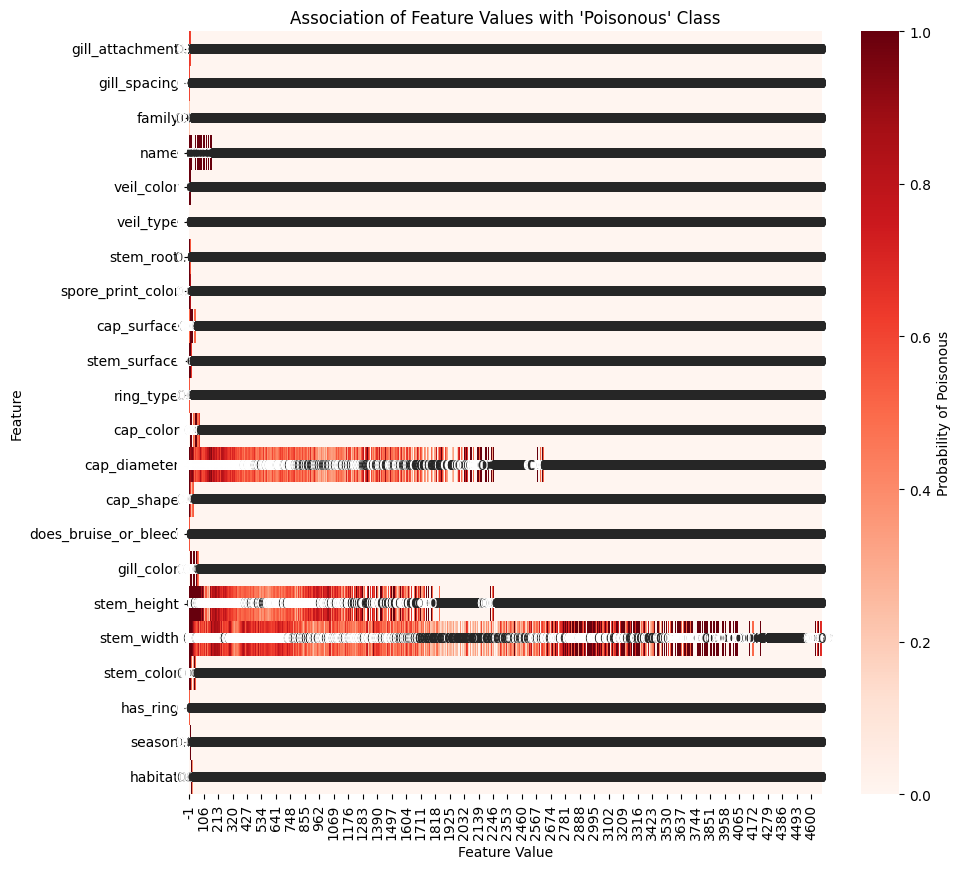

In [46]:
# Convert index and columns to categorical without sorting
poisonous_df.index = pd.Categorical(poisonous_df.index, categories=poisonous_df.index, ordered=True)
poisonous_df.columns = pd.Categorical(poisonous_df.columns, categories=poisonous_df.columns, ordered=True)

# Then plot
plt.figure(figsize=(10, len(poisonous_df) * 0.4))
sns.heatmap(poisonous_df, annot=True, cmap="Reds", cbar_kws={'label': 'Probability of Poisonous'})
plt.title("Association of Feature Values with 'Poisonous' Class")
plt.xlabel("Feature Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Overwhelming, to much data... Lets focus

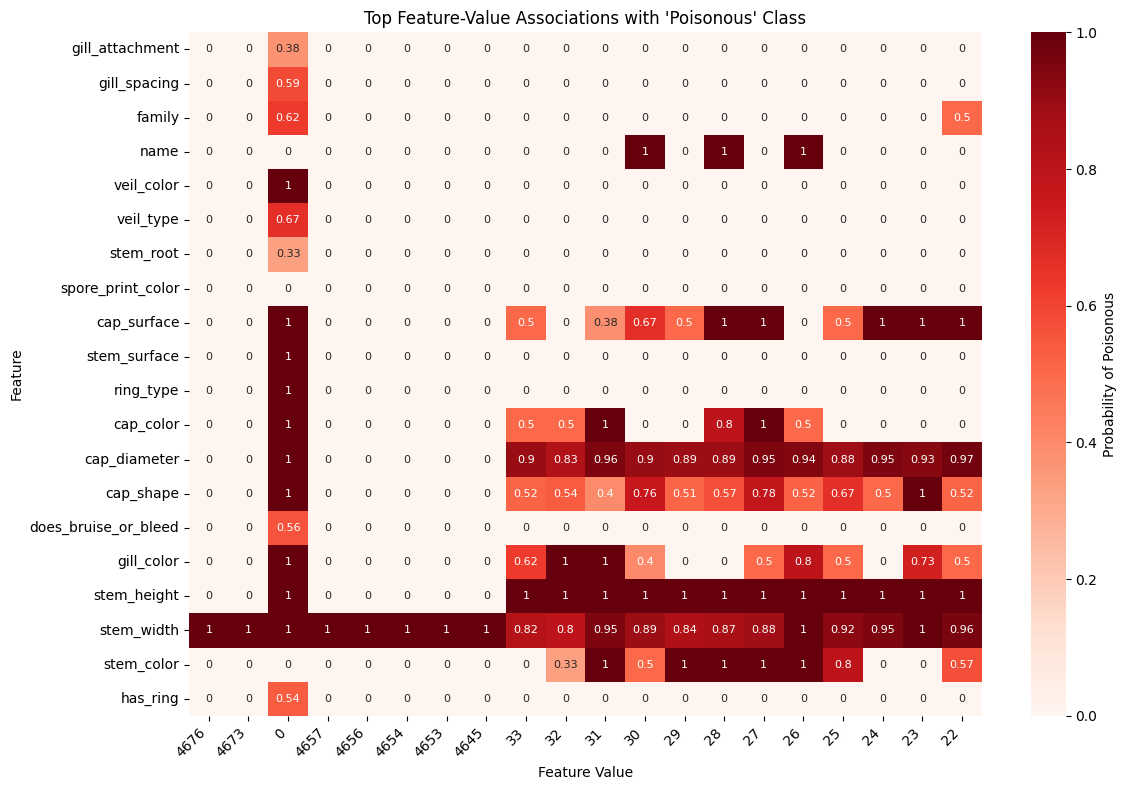

In [52]:
# Define how many feature values (columns) to keep
TOP_VALUES = 20  # adjust as needed

# Find top N columns (feature values) based on their max contribution
top_columns = poisonous_df.max().sort_values(ascending=False).head(TOP_VALUES).index

# Subset to top feature values only
poisonous_subset = poisonous_df[top_columns]

# Optional: Limit number of rows (features) as well
TOP_FEATURES = 20
poisonous_subset = poisonous_subset.iloc[:TOP_FEATURES]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(poisonous_subset, annot=True, cmap="Reds", cbar_kws={'label': 'Probability of Poisonous'},
            annot_kws={"size": 8})
plt.title("Top Feature-Value Associations with 'Poisonous' Class")
plt.xlabel("Feature Value")
plt.ylabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [59]:
# ----------------------------
# 1. ENCODE CATEGORICAL COLUMNS
# ----------------------------
target = 'class'
categorical_cols = combined_df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove(target)

# Ensure all values are strings (avoid type mix)
for col in categorical_cols + [target]:
    combined_df[col] = combined_df[col].astype(str)

# Encode features
le = LabelEncoder()
X_encoded = combined_df[categorical_cols].apply(le.fit_transform)
y_encoded = le.fit_transform(combined_df[target])

# ----------------------------
# 2. TRAIN RANDOM FOREST
# ----------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded, y_encoded)

# Get feature importance
feature_importances = pd.Series(rf.feature_importances_, index=categorical_cols)
top_n = 10
top_features = feature_importances.sort_values(ascending=False).head(top_n).index.tolist()
print(f"Top {top_n} features by Random Forest:\n", top_features)

# ----------------------------
# 3. BUILD POISONOUS ASSOCIATION MATRIX
# ----------------------------
# Work on original (non-encoded) data for clarity
poisonous_matrix = {}

for col in top_features:
    ct = pd.crosstab(combined_df[col], combined_df[target], normalize='index')
    if 'p' in ct.columns:
        poisonous_matrix[col] = ct['p']
    else:
        poisonous_matrix[col] = pd.Series(0, index=ct.index)

# Build matrix
poisonous_df = pd.DataFrame(poisonous_matrix).T  # Transpose

# Optional: sort by max 'p' value
poisonous_df = poisonous_df.sort_values(by=poisonous_df.columns[0], ascending=False)

# ----------------------------
# 4. PLOT HEATMAP
# ----------------------------
plt.figure(figsize=(12, len(poisonous_df) * 0.5))
sns.heatmap(poisonous_df, annot=True, cmap="Reds", cbar_kws={'label': 'Probability of Poisonous'})
plt.title("Top Features (Random Forest) Associated with 'Poisonous' Class")
plt.xlabel("Feature Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


NameError: name 'RandomForestClassifier' is not defined